<a href="https://colab.research.google.com/gist/CraigStr/be9cdeb91df7fbab71834988486dec83/cnnlstm-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from tensorboard.plugins.hparams import api as hp

import unittest

from typing import Optional, Tuple, Dict, List
import os
import random
from datetime import datetime

np.set_printoptions(precision=4)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Constants
dataset_path = '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset'
saved_files = '/content/saved_files'

tf.random.set_seed(
    1234
#     random.random()
)

In [24]:
def get_all_user_file_paths(user: str) -> List[str]:
    """
    Get absolute paths of all keystroke files belonging to a user
    
    Parameters:
        user (String): userID of user
        
    Returns (List): List of absolute paths
    """
    file_names = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
          if file.startswith(user):
            path = os.path.join(root, file)
            file_names.append(path)
    return file_names

get_all_user_file_paths("005")

['/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s0/baseline/005001.txt',
 '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s0/baseline/005000.txt',
 '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s1/baseline/005100.txt',
 '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s1/baseline/005101.txt',
 '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s2/baseline/005200.txt',
 '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s2/baseline/005201.txt']

Data Processing
===
Anything printed or stored in variables under a function is just to show the structure of each of the function outputs. No global variable in this section is used in the training data.  
All functions here are called in ```read_and_process_data()` in the next section

___

Converts raw keystroke data `(Key, Action, Timestamp)`
To sliding window `[(Hold Time, UD Time, DD Time)]` of sequence length 30.

<sub>UD = Time between key release and next key down</sub>  
<sub>DD = Time between key press and next key press</sub>

In [25]:
def split_user_filename(filename: str) -> List[str]:
  """
  Split Buffalo Dataset filename into its respective parts
  
    Parameters:
      filename (string): filename of keystroke file to be read, without extension
    
    Returns:
      Tuple: (user_id, session, keyboard, task) 
  """
  user_id, session, keyboard, task = filename[:3], filename[3], filename[4], filename[5]
  return user_id, session, keyboard, task

In [26]:
def read_buffalo_user_data(user_id: str, session: str, keyboard: str, task: str, impostor: Optional[bool] = False) -> np.ndarray:
  """
  Generate np array from Buffalo KD file
    [Key, Action, Timestamp]
  """
  dtype = np.dtype([("Key",np.str, 16),
                    ("Action", np.str, 16),
                    ("Timestamp", np.int64)])
  
  folder = "rotation" if impostor else "baseline"
  
  return np.loadtxt(f"{dataset_path}/s{session}/{folder}/{user_id}{session}{keyboard}{task}.txt",
                    delimiter=" " ,
                    dtype=dtype)

In [27]:
def read_buffalo_user_data_from_path(path: str) -> np.ndarray:
  """
  Generate np array from Buffalo KD file
    [Key, Action, Timestamp]
  """
  dtype = np.dtype([("Key",np.str, 16),
                    ("Action", np.str, 16),
                    ("Timestamp", np.int64)])
      
  return np.loadtxt(path,
                    delimiter=" " ,
                    dtype=dtype)

In [28]:
def split_down_up(arr: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  """
  Split Keystrokes into KeyDowns and KeyUps

  Parameters:
    arr (np.array): np array containing raw keystroke data read from .txt file

  Returns:
    Tuple: (all rows of input array where KeyDown, all rows of input array where KeyUp)
  """
  key_ups = arr[np.where(arr["Action"] == "KeyUp")]
  key_downs = arr[np.where(arr["Action"] == "KeyDown")]
  return key_ups, key_downs

In [29]:
def match_press_release(arr: np.ndarray) -> np.ndarray:
  """
  Convert KeyUp & KeyDown to [key, press_timestamp, release_timestamp]

  Parameters:
    arr (Tuple): containing two arrays.
                  1. List of all KeyDown lines in file.
                  2. List of all KeyUp lines in file.
  
  Returns:
    array: [
              [Key:String, KeyDownTimestamp:Int, KeyUpTimestamp:Int]
           ]
  """
  key_ups, key_downs = arr
  len_key_ups = len(key_ups)
  len_key_downs = len(key_downs)
  stack = [] # Store pressed keys waiting to be released

  dtype = np.dtype([("Key", np.str, 16),
                    ("Press", np.int64),
                    ("Release", np.int64)])
  timings = np.empty((0,3), dtype=dtype)

  max_iter = max([len_key_ups, len_key_downs])
  
  # Output Array : [
  #                 ( Key:String, KeyDownTimestamp:Int, KeyUpTimestamp:Int ),
  #                 ...
  #                ]
  # 
  # 1. Key depressed after press, no inetween keys
  #   - i.e. ('LControlKey', 'KeyDown', 63578875355302),
  #          ('LControlKey', 'KeyUp', 63578875355962)
  #   1. Add to output and pop both from input arrays.
  # 2. Inbetween keys
  #   - i.e. ('LControlKey', 'KeyDown', 63578875355302),
  #          ('Down', 'KeyDown', 63578875355703)
  #          ('LControlKey', 'KeyUp', 63578875355962)
  #   1. Search for key corresponding KeyUp until end of list
  #   2. If corresponding KeyUp not found, pop the KeyDown
  #   3. If corresponding KeyUp found, 
  #      1. Check if there was a the same key has been pressed between original 
  #         KeyDown and KeyUp. If there was, the KeyUp event for that key was
  #         missed
  #      2. If second Keydown occurs as above, pop the original Keydown 
  #   4. Add to output, pop both press and depress

  # Always operate on 1st in key_ups.
  # Pop both keyup and keydown from their arrays

  for i in range(len_key_downs):
    # Key depress straight after press
    if key_downs.size != 0 != key_ups.size:
        if key_ups[0][0] == key_downs[0][0]:
          # Add to output
          key_id = key_downs[0]["Key"]
          key_down_time = key_downs[0]["Timestamp"]
          key_up_time = key_ups[0]["Timestamp"]

          temp = np.array((key_id, key_down_time, key_up_time), dtype=dtype)
          timings = np.append(timings, temp)
          # Pop from input lists
          key_ups = np.delete(key_ups, 0)
          key_downs = np.delete(key_downs, 0)
        else:
          # Search for the corresponding key release
          found = False;
          for j in range(len(key_ups)):
            # Found a corresponging release
            if key_downs[0][0] == key_ups[j][0]:
              # Get presses between press & discovered release
              keys_between = key_downs[key_downs["Timestamp"] < key_ups[j][2]][1:]
              # If there is another press, ignore the original press
              if key_downs[0][0] in keys_between["Key"]:
                print("FOUND BETWEEN - DROPPING", i,  key_downs[0])
                key_downs = np.delete(key_downs, 0)
              else:
                # Add to output
                key_id = key_downs[0]["Key"]
                key_down_time = key_downs[0]["Timestamp"]
                key_up_time = key_ups[j]["Timestamp"]

                temp = np.array((key_id, key_down_time, key_up_time), dtype=dtype)
                timings = np.append(timings, temp)
                # Pop from input lists
                key_downs = np.delete(key_downs, 0)
                key_ups = np.delete(key_ups, j)

              found = True
              break;
          if not found:
            # Ignore key press, as there is no corresopnding release
            print("NOT FOUND, IGNORING", key_downs[0])
            # Pop from input list
            key_downs = np.delete(key_downs, 0)

  return timings

In [30]:
def to_timing_vector(timings: np.ndarray) -> np.ndarray:
  """
  Convert Press-Release to [Key, Hold Time, UD, DD]
  """
  dtype = np.dtype([("Hold", np.str, 16),
                    ("UD", np.int64),
                    ("DD", np.int64)])
  
  # shift array by one, so shifted[n] will be the keystroke that too place after timings[n]
  shifted = np.array(timings[1:])

  # Append line at end to make length equal to original 'timings' array
  shifted = np.append(shifted, np.array(("ADDED",
                                         shifted[-1]["Press"],
                                         shifted[-1]["Release"]),
                                        dtype=shifted.dtype))
  
  features = np.hstack([np.c_[timings["Release"]-timings["Press"]], # Hold Time
                        np.c_[shifted["Press"]-timings["Release"]], # UD Time
                        np.c_[shifted["Press"]-timings["Press"]]])  # DD Time
  
  # Add features back onto key name
  vector = np.hstack([np.c_[timings["Key"]],
                      features])
  return vector

In [31]:
def normalise(arr: np.ndarray) -> np.ndarray:
  """
  Normalise data
  """
  arr_tail = np.asfarray(np.array(arr[:, 1:]))             # Ints to Floats
  arr_tail = arr_tail / np.linalg.norm(arr_tail)           # Normalise
  # return np.hstack([np.c_[arr[:, 0]], arr_tail])
  # return np.hstack([np.c_[np.arange(len(arr))], arr_tail]) # hstack the normalised features
  # return np.hstack([np.c_[np.arange(len(arr))], arr_tail]) # change key name to index, hstack the normalised features
  return arr_tail

In [32]:
def reshape_to_3d(arr: np.ndarray) -> np.ndarray:
  # new = np.array([])
  # for row in range(len(arr)):
  #   new = np.append(new, np.reshape(arr[row], (4, 1)))
  # return new
  return np.reshape(arr, (len(arr), 3, 1))

In [33]:
def vec_to_window(arr: np.ndarray, window_size: int) -> np.ndarray:
  """
  Create Sliding Window from arr of size window_size.

  Returns: 
    3D array, m * window_size * 4
    e.g.
    [
      [   # Window 1
        [ 0.0000e+00,       2.7928e-03,  3.9268e-04,  3.1855e-03],
        [ 1.0000e+00,       4.9007e-04,  1.9477e-04,  6.8484e-04],
        [ 2.0000e+00,       4.3981e-04,  3.7735e-02,  3.8175e-02],
        ...
        [ window_size,      2.4503e-04,  4.3981e-04,  6.8484e-04]
      ],
      [   # Window 2
        [ 1.0000e+00,       4.9007e-04,  1.9477e-04,  6.8484e-04],
        [ 2.0000e+00,       4.3981e-04,  3.7735e-02,  3.8175e-02],
        [ 3.0000e+00,       4.4295e-04, -4.4295e-04,  0.0000e+00],
        ...
        [ window_size + 1,  1.1278e-03, -2.9530e-04,  8.3249e-04]
      ],
      ...
      [   # Window m
        [ n - window_size,      2.6074e-04,  2.2524e-03,  2.5132e-03],
        [ n - window_size + 1,  1.0681e-04,  4.3949e-03,  4.5017e-03],
        [ n - window_size + 2,  2.5132e-04,  1.3339e-02,  1.3590e-02],
        ...
        [ n,  2.0734e-03, -2.0734e-03,  0.0000e+00]
      ]
    ]
  """
  return np.array([np.array(arr[i : window_size + i]) for i in range(len(arr) - window_size + 1)])

Training 
===

In [34]:
def auroc(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

def create_CNNLSTM(input_shape: Tuple[int, int, int]):
  """
  Create CNN-LSTM Model
  """

  num_filters = 64
  kernel_size = 2
  input_shape
  lstm_stateful = False
  drop_out = 0.4
  num_rnn_cells = 100
  learning_rate= 0.0005

  model = Sequential([
  # CNN Layers
    TimeDistributed(Conv1D(num_filters,
                           kernel_size=kernel_size,
                           activation="relu"),
                    input_shape=input_shape),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),

    # LSTM Layers
    LSTM(num_rnn_cells,
         stateful=lstm_stateful,
         return_sequences=True,
         dropout=drop_out),
    LSTM(num_rnn_cells,
         stateful=lstm_stateful,
         return_sequences=True,
         dropout=drop_out),
    LSTM(num_rnn_cells,
         stateful=lstm_stateful,
         dropout=0.3),
    
    Flatten(),

    BatchNormalization(),

    Dense(num_rnn_cells, activation='relu'),
    Dropout(drop_out),
    Dense(num_rnn_cells, activation='relu'),
    Dropout(drop_out),
    Dense(1, activation='sigmoid'),
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate,
                                                   beta_1=0.9,
                                                   beta_2=0.999,
                                                   epsilon=1e-08, decay=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy', auroc])
  return model

# create_CNNLSTM((30, 3, 1), [2, 2, 0.3, 80, 'adam']).summary()

In [35]:
# Runs all data processing code above (except the Classifier code)
def read_and_process_data(path: str) -> np.ndarray:
  """
  Returns processed data to train / test on

  Parameters:
    filename (string): Filename of sample without extension
    impostor (Boolean): User is impostor
  Returns:
    Processed data ready to be fed into train/test functions  
  """
  data = read_buffalo_user_data_from_path(path)
  data = split_down_up(data)
  data = match_press_release(data)
  data = to_timing_vector(data)
  data = normalise(data)
  data = reshape_to_3d(data)
  data = vec_to_window(data, 30)
  return data

In [36]:
def save_model(model: tf, user_id: str, impostor_id: str) -> None:
  current_time = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
  tf.keras.models.save_model(model, f'{saved_files}/{current_time} {user_id}vs{impostor_id}', save_format="h5")

In [37]:
def perform_training(x_pos_train: np.ndarray, x_neg_train: np.ndarray, epochs: Optional[int]=1000, batch_size: Optional[int]=64, validation_split: Optional[float]=0.3):
  
  # print({"Pos Length": len(x_pos_train), "Neg Length": len(x_neg_train)})

  # Make same size so no funny TF errors
  min_len = min(len(x_pos_train), len(x_neg_train))
  x_neg_train = x_neg_train[:min_len]
  x_pos_train = x_pos_train[:min_len]

  # Combine genuine user and impostor
  x_train = np.vstack([x_pos_train, x_neg_train])
  # Generate labels for the above data
  y_train = np.vstack([np.ones(shape=(len(x_pos_train), 1)),
                       np.zeros(shape=(len(x_neg_train), 1))])

  # Shuffle Data
  for i in range(10):
    x_train, y_train = shuffle(x_train, y_train)

  # print("Training shape:",x_train.shape)

  model = create_CNNLSTM((30, 3, 1))

  unique, counts = np.unique(y_train, return_counts=True)
  # print("True counts:", dict(zip(unique, counts)))
  
  history = model.fit(x_train,
                      y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=validation_split,
                      # callbacks=[
                      #     tf.keras.callbacks.TensorBoard("./logs/hparam_tuning"),  # log metrics
                      #     hp.KerasCallback("./logs/hparam_tuning", hparams),  # log hparams
                      # ],
                     )
  return model, history

In [38]:
def perform_testing(model, test_pos: np.ndarray, test_neg: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

    print("True Count:", {0.0: len(test_neg),

                          1.0: len(test_pos)})

    x_test = np.vstack([test_pos, test_neg])
    y_test = np.vstack([np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1))])

    prediction = model.predict(x_test)

    # Round to nearest unit. < .5: Impostor : > .5: Genuine
    y_pred = np.round(prediction, 0)
    print("Predicted Count:", dict(zip(*np.unique(y_pred, return_counts=True))), end="\n\n")

    print("Accuracy:", np.sum(y_pred == y_test) / len(y_test))

    return y_pred, y_test

In [39]:
def get_random_users(count: int) -> List[str]:
    users = []
    for i in range(count):
        users.append(str(random.randrange(1,149)).zfill(3))
    return users

# users_id = get_random_users(7)
# impostors_id = get_random_users(2)

users_id = ['113', '132', '086', '123', '126', '138', '055']
impostors_id = ['050', '012']


# users_id = ['113']
# impostors_id = ['050']

genuine_users = []
users_test = []

impostors = []
impostors_test = []

for user in users_id:
    data = [read_and_process_data(x) for x in get_all_user_file_paths(user)]
    users_test.append(data[-1])
    genuine_users.append(np.vstack([*data[:-1]]))

for impostor in impostors_id:
    data = [read_and_process_data(x) for x in get_all_user_file_paths(impostor)]    
    impostors_test.append(data[-1])
    impostors.append(np.vstack([*data[:-1]]))

# print(genuine_users[0])
# print(impostors[0])
# print(users_test[0])
# print(impostors_test[0])

FOUND BETWEEN - DROPPING 190 ('OemPeriod', 'KeyDown', 63579031852056)
FOUND BETWEEN - DROPPING 1585 ('LShiftKey', 'KeyDown', 63579032383642)
FOUND BETWEEN - DROPPING 2251 ('LShiftKey', 'KeyDown', 63582056210288)
FOUND BETWEEN - DROPPING 1411 ('LShiftKey', 'KeyDown', 63582057140003)
FOUND BETWEEN - DROPPING 1032 ('LShiftKey', 'KeyDown', 63583871416090)
NOT FOUND, IGNORING ('Right', 'KeyDown', 63577823380482)
FOUND BETWEEN - DROPPING 2691 ('LShiftKey', 'KeyDown', 63580245389258)
FOUND BETWEEN - DROPPING 1411 ('Right', 'KeyDown', 63580246445553)
FOUND BETWEEN - DROPPING 667 ('LShiftKey', 'KeyDown', 63579038543599)
FOUND BETWEEN - DROPPING 1610 ('LShiftKey', 'KeyDown', 63580850911848)
FOUND BETWEEN - DROPPING 1408 ('LShiftKey', 'KeyDown', 63580849524912)
FOUND BETWEEN - DROPPING 1573 ('LShiftKey', 'KeyDown', 63580849563615)
FOUND BETWEEN - DROPPING 3170 ('LShiftKey', 'KeyDown', 63580849947813)
FOUND BETWEEN - DROPPING 3303 ('LShiftKey', 'KeyDown', 63580849980370)
FOUND BETWEEN - DROPPING 1

In [42]:
model_1, history_1 = perform_training(genuine_users[0], impostors[0], epochs=100)
save_model(model_1, users_id[0], impostors_id[0])

test_pos = users_test[0]
test_neg = impostors_test[0]

y_pred_1, y_true_1 = perform_testing(model_1, test_pos, test_neg)

test_pos = users_test[0]
test_neg = impostors_test[1]

y_pred_1_unseen, y_true_1_unseen = perform_testing(model_1, test_pos, test_neg)

True Count: {0.0: 4042, 1.0: 1473}
Predicted Count: {0.0: 5458, 1.0: 57}

Accuracy: 0.74324569356301
True Count: {0.0: 2177, 1.0: 1473}
Predicted Count: {0.0: 2696, 1.0: 954}

Accuracy: 0.3663013698630137


In [43]:
model_2, history_2 = perform_training(genuine_users[1], impostors[0], epochs=100)
save_model(model_2, users_id[1], impostors_id[0])

test_pos = users_test[1]
test_neg = impostors_test[0]

y_pred_2, y_true_2 = perform_testing(model_2, test_pos, test_neg)

test_pos = users_test[1]
test_neg = impostors_test[1]

y_pred_2_unseen, y_true_2_unseen = perform_testing(model_2, test_pos, test_neg)

True Count: {0.0: 4042, 1.0: 1240}
Predicted Count: {0.0: 4970, 1.0: 312}

Accuracy: 0.7444149943203332
True Count: {0.0: 2177, 1.0: 1240}
Predicted Count: {0.0: 3052, 1.0: 365}

Accuracy: 0.5894059116183787


In [44]:
# model_3, history_3 = perform_training(genuine_users[2], impostors[0], epochs=100)
# save_model(model_3, users_id[2], impostors_id[0])

# test_pos = users_test[2]
# test_neg = impostors_test[0]

# y_pred_3, y_true_3 = perform_testing(model_3, test_pos, test_neg)

# test_pos = users_test[2]
# test_neg = impostors_test[1]

# y_pred_3_unseen, y_true_3_unseen = perform_testing(model_3, test_pos, test_neg)

In [45]:
model_4, history_4 = perform_training(genuine_users[3], impostors[0], epochs=100)
save_model(model_4, users_id[3], impostors_id[0])

test_pos = users_test[3]
test_neg = impostors_test[0]

y_pred_4, y_true_4 = perform_testing(model_4, test_pos, test_neg)

test_pos = users_test[3]
test_neg = impostors_test[1]

y_pred_4_unseen, y_true_4_unseen = perform_testing(model_4, test_pos, test_neg)

True Count: {0.0: 4042, 1.0: 1193}
Predicted Count: {0.0: 3374, 1.0: 1861}

Accuracy: 0.8112702960840497
True Count: {0.0: 2177, 1.0: 1193}
Predicted Count: {0.0: 389, 1.0: 2981}

Accuracy: 0.3744807121661721


In [46]:
model_5, history_5 = perform_training(genuine_users[4], impostors[0], epochs=100)
save_model(model_5, users_id[4], impostors_id[0])

test_pos = users_test[4]
test_neg = impostors_test[0]

y_pred_5, y_true_5 = perform_testing(model_5, test_pos, test_neg)

test_pos = users_test[4]
test_neg = impostors_test[1]

y_pred_5_unseen, y_true_5_unseen = perform_testing(model_5, test_pos, test_neg)

True Count: {0.0: 4042, 1.0: 1001}
Predicted Count: {0.0: 2600, 1.0: 2443}

Accuracy: 0.7140590918104303
True Count: {0.0: 2177, 1.0: 1001}
Predicted Count: {0.0: 154, 1.0: 3024}

Accuracy: 0.3634361233480176


In [47]:
model_6, history_6 = perform_training(genuine_users[5], impostors[0], epochs=100)
save_model(model_6, users_id[5], impostors_id[0])

test_pos = users_test[5]
test_neg = impostors_test[0]

y_pred_6, y_true_6 = perform_testing(model_6, test_pos, test_neg)

test_pos = users_test[5]
test_neg = impostors_test[1]

y_pred_6_unseen, y_true_6_unseen = perform_testing(model_6, test_pos, test_neg)

True Count: {0.0: 4042, 1.0: 1796}
Predicted Count: {0.0: 1192, 1.0: 4646}

Accuracy: 0.16752312435765673
True Count: {0.0: 2177, 1.0: 1796}
Predicted Count: {0.0: 1458, 1.0: 2515}

Accuracy: 0.31311351623458344


In [48]:
model_7, history_7 = perform_training(genuine_users[6], impostors[0], epochs=100)
save_model(model_7, users_id[6], impostors_id[0])

test_pos = users_test[6]
test_neg = impostors_test[0]

y_pred_7, y_true_7 = perform_testing(model_7, test_pos, test_neg)

test_pos = users_test[6]
test_neg = impostors_test[1]

y_pred_7_unseen, y_true_7_unseen = perform_testing(model_7, test_pos, test_neg)

True Count: {0.0: 4042, 1.0: 2154}
Predicted Count: {0.0: 1574, 1.0: 4622}

Accuracy: 0.09360877985797289
True Count: {0.0: 2177, 1.0: 2154}
Predicted Count: {0.0: 3211, 1.0: 1120}

Accuracy: 0.5118910182405911


In [51]:
def load_model(filename):
  return tf.keras.models.load_model(f"{saved_files}/{filename}", custom_objects={'auroc': auroc})

# model_1 = load_model(" 18-03-2021 18:45:05 001vs080")
# model_2 = load_model(" 18-03-2021 18:45:06 005vs080")
# model_3 = load_model(" 18-03-2021 18:45:06 010vs080")
# weights = model_1.weights

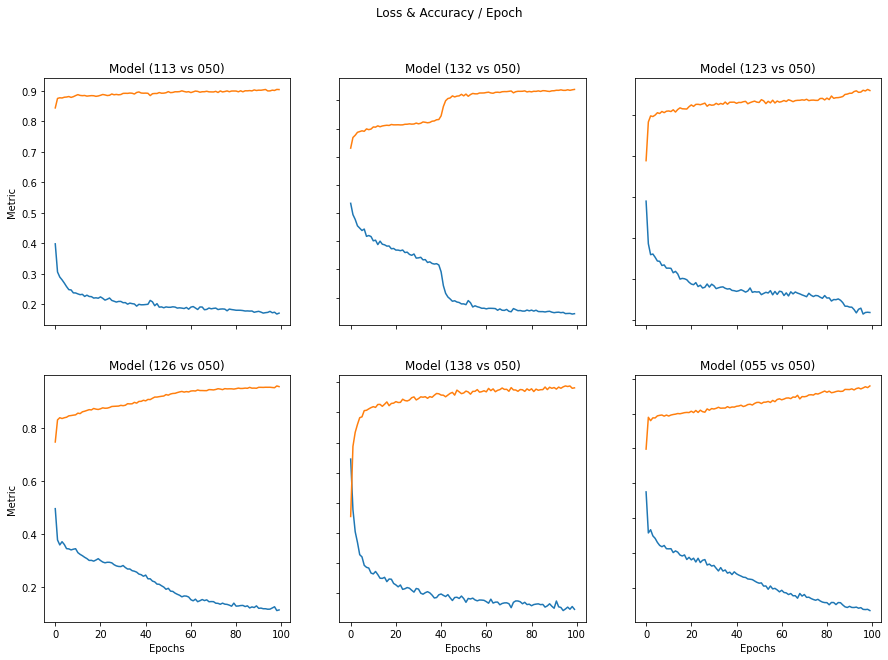

In [54]:
# Plot Arruracy / Loss
figure, axis = plt.subplots(2,3, figsize=(15,10))
figure.suptitle('Loss & Accuracy / Epoch')

axis[0][0].set_title(f"Model ({users_id[0]} vs {impostors_id[0]})")
axis[0][1].set_title(f"Model ({users_id[1]} vs {impostors_id[0]})")
# axis[0][2].set_title(f"Model ({users_id[2]} vs {impostors_id[0]})")
axis[0][2].set_title(f"Model ({users_id[3]} vs {impostors_id[0]})")
axis[1][0].set_title(f"Model ({users_id[4]} vs {impostors_id[0]})")
axis[1][1].set_title(f"Model ({users_id[5]} vs {impostors_id[0]})")
axis[1][2].set_title(f"Model ({users_id[6]} vs {impostors_id[0]})")

epochs_1 = history_1.epoch
history_dict_1 = history_1.history
sns.lineplot(x=epochs_1, y=history_dict_1["loss"], ax=axis[0][0])
sns.lineplot(x=epochs_1, y=history_dict_1["accuracy"], ax=axis[0][0])

epochs_2 = history_2.epoch
history_dict_2 = history_2.history
sns.lineplot(x=epochs_2, y=history_dict_2["loss"], ax=axis[0][1])
sns.lineplot(x=epochs_2, y=history_dict_2["accuracy"], ax=axis[0][1])

# epochs_3 = history_3.epoch
# history_dict_3 = history_3.history
# sns.lineplot(x=epochs_3, y=history_dict_3["loss"], ax=axis[0][2])
# sns.lineplot(x=epochs_3, y=history_dict_3["accuracy"], ax=axis[0][2])

epochs_4 = history_4.epoch
history_dict_4 = history_4.history
sns.lineplot(x=epochs_4, y=history_dict_4["loss"], ax=axis[0][2])
sns.lineplot(x=epochs_4, y=history_dict_4["accuracy"], ax=axis[0][2])

epochs_5 = history_5.epoch
history_dict_5 = history_5.history
sns.lineplot(x=epochs_5, y=history_dict_5["loss"], ax=axis[1][0])
sns.lineplot(x=epochs_5, y=history_dict_5["accuracy"], ax=axis[1][0])

epochs_6 = history_6.epoch
history_dict_6 = history_6.history
sns.lineplot(x=epochs_6, y=history_dict_6["loss"], ax=axis[1][1])
sns.lineplot(x=epochs_6, y=history_dict_6["accuracy"], ax=axis[1][1])

epochs_7 = history_7.epoch
history_dict_7 = history_7.history
sns.lineplot(x=epochs_7, y=history_dict_7["loss"], ax=axis[1][2])
sns.lineplot(x=epochs_7, y=history_dict_7["accuracy"], ax=axis[1][2])


for ax in axis.flat:
    ax.set(xlabel='Epochs', ylabel='Metric')
    ax.label_outer()

# Save Loss Accuracy Graph
plt.savefig(f'{saved_files}/Accuracy vs Loss {users_id} vs {impostors_id}.png')

plt.show()

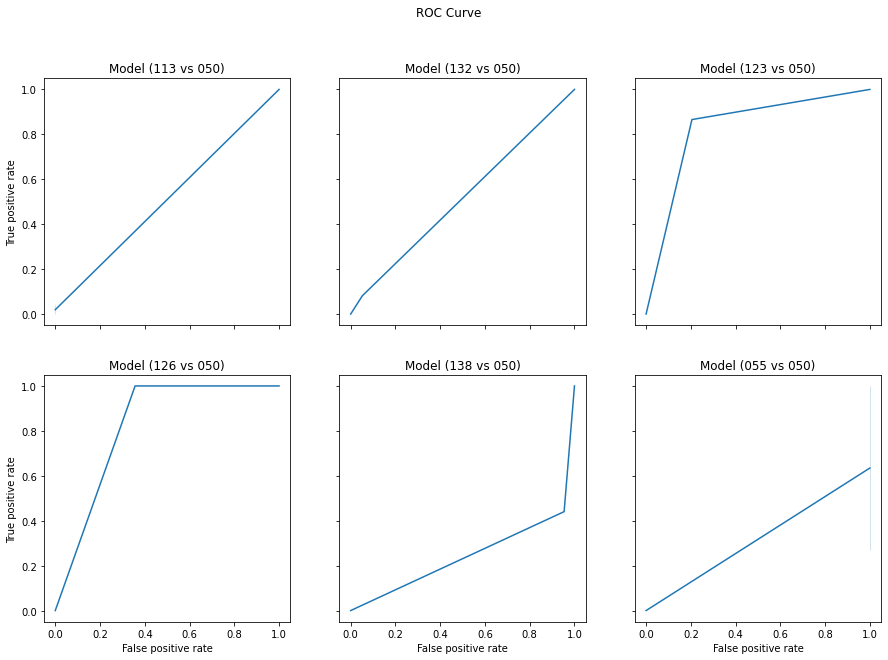

In [55]:
# Plot ROC Curve

from sklearn.metrics import roc_curve, auc

figure, axis = plt.subplots(2,3, figsize=(15,10))
figure.suptitle('ROC Curve')

axis[0][0].set_title(f"Model ({users_id[0]} vs {impostors_id[0]})")
axis[0][1].set_title(f"Model ({users_id[1]} vs {impostors_id[0]})")
# axis[0][2].set_title(f"Model ({users_id[2]} vs {impostors_id[0]})")
axis[0][2].set_title(f"Model ({users_id[3]} vs {impostors_id[0]})")
axis[1][0].set_title(f"Model ({users_id[4]} vs {impostors_id[0]})")
axis[1][1].set_title(f"Model ({users_id[5]} vs {impostors_id[0]})")
axis[1][2].set_title(f"Model ({users_id[6]} vs {impostors_id[0]})")


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_1, y_pred_1)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][0])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_2, y_pred_2)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][1])

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_3, y_pred_3)
# auc_keras = auc(fpr_keras, tpr_keras)
# sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][2])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_4, y_pred_4)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][2])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_5, y_pred_5)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[1][0])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_6, y_pred_6)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[1][1])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_7, y_pred_7)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[1][2])


for ax in axis.flat:
    ax.set(xlabel='False positive rate', ylabel='True positive rate')
    ax.label_outer()
    

# Save ROC Curve
plt.savefig(f'{saved_files}/ROC Curve (Seen User) {users_id}vs{impostors_id}.png')

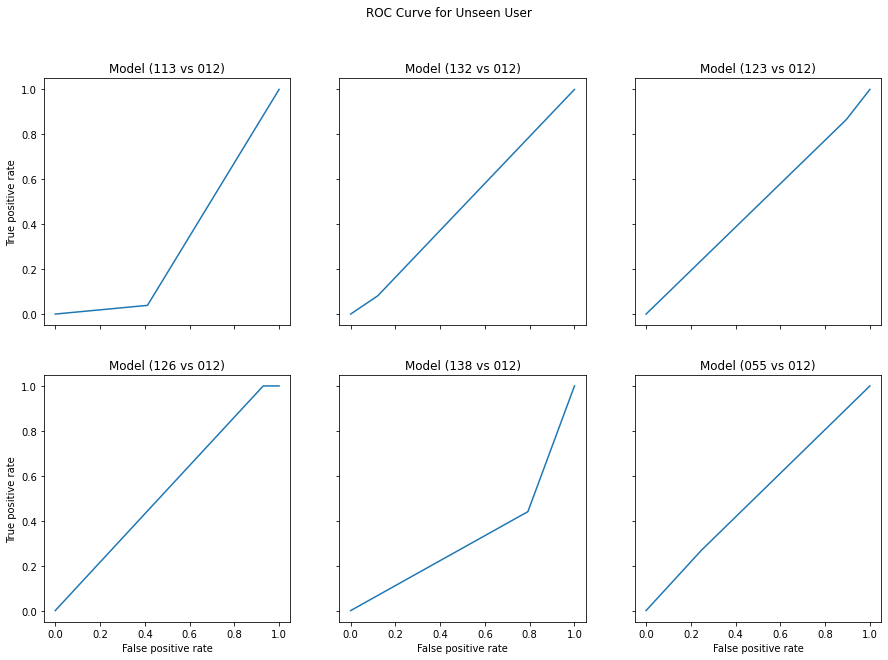

In [56]:
# Plot ROC Curve

from sklearn.metrics import roc_curve, auc

figure, axis = plt.subplots(2,3, figsize=(15,10))
figure.suptitle('ROC Curve for Unseen User')

axis[0][0].set_title(f"Model ({users_id[0]} vs {impostors_id[1]})")
axis[0][1].set_title(f"Model ({users_id[1]} vs {impostors_id[1]})")
# axis[0][2].set_title(f"Model ({users_id[2]} vs {impostors_id[1]})")
axis[0][2].set_title(f"Model ({users_id[3]} vs {impostors_id[1]})")
axis[1][0].set_title(f"Model ({users_id[4]} vs {impostors_id[1]})")
axis[1][1].set_title(f"Model ({users_id[5]} vs {impostors_id[1]})")
axis[1][2].set_title(f"Model ({users_id[6]} vs {impostors_id[1]})")


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_1_unseen, y_pred_1_unseen)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][0])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_2_unseen, y_pred_2_unseen)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][1])

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_3_unseen, y_pred_3_unseen)
# auc_keras = auc(fpr_keras, tpr_keras)
# sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][2])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_4_unseen, y_pred_4_unseen)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[0][2])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_5_unseen, y_pred_5_unseen)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[1][0])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_6_unseen, y_pred_6_unseen)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[1][1])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_7_unseen, y_pred_7_unseen)
auc_keras = auc(fpr_keras, tpr_keras)
sns.lineplot(x=fpr_keras, y=tpr_keras, ax=axis[1][2])


for ax in axis.flat:
    ax.set(xlabel='False positive rate', ylabel='True positive rate')
    ax.label_outer()
    

# Save ROC Curve
plt.savefig(f'{saved_files}/ROC Curve (Unseen User) {users_id}vs{impostors_id}.png')

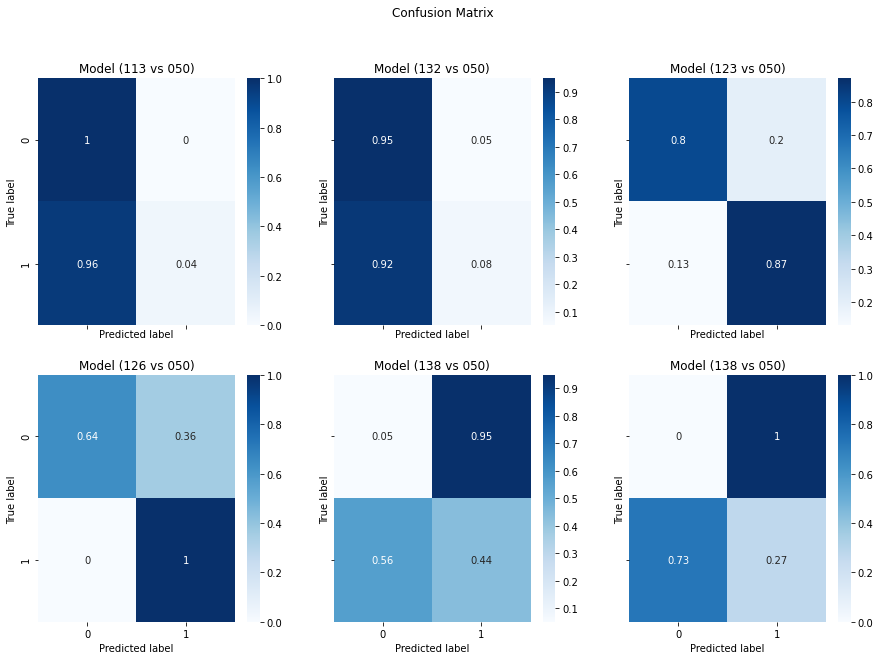

In [57]:
# Plot Confusion Matrix

figure, axis = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True)
figure.suptitle('Confusion Matrix')

def generate_con_mat_df(y_true, y_pred):

  con_mat = confusion_matrix(y_true=y_true,
                             y_pred=y_pred)
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  return pd.DataFrame(con_mat_norm)

axis[0][0].set_title(f"Model ({users_id[0]} vs {impostors_id[0]})")
axis[0][1].set_title(f"Model ({users_id[1]} vs {impostors_id[0]})")
# axis[0][2].set_title(f"Model ({users_id[2]} vs {impostors_id[0]})")
axis[0][2].set_title(f"Model ({users_id[3]} vs {impostors_id[0]})")
axis[1][0].set_title(f"Model ({users_id[4]} vs {impostors_id[0]})")
axis[1][1].set_title(f"Model ({users_id[5]} vs {impostors_id[0]})")
axis[1][2].set_title(f"Model ({users_id[5]} vs {impostors_id[0]})")

sns.heatmap(generate_con_mat_df(y_true_1, y_pred_1),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[0][0])
sns.heatmap(generate_con_mat_df(y_true_2, y_pred_2),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[0][1])
# sns.heatmap(generate_con_mat_df(y_true_3, y_pred_3),
#             annot=True,
#             cmap=plt.cm.Blues, 
#             ax=axis[0][2])
sns.heatmap(generate_con_mat_df(y_true_4, y_pred_4),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[0][2])
sns.heatmap(generate_con_mat_df(y_true_5, y_pred_5),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[1][0])
sns.heatmap(generate_con_mat_df(y_true_6, y_pred_6),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[1][1])
sns.heatmap(generate_con_mat_df(y_true_7, y_pred_7),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[1][2])

for ax in axis.flat:
    ax.set(xlabel='Predicted label', ylabel='True label')
#     ax.label_outer()

# Save Confusion Matrix
plt.savefig(f'{saved_files}/Confusion Matrix (Seen User) {users_id} vs {impostors_id}.png')

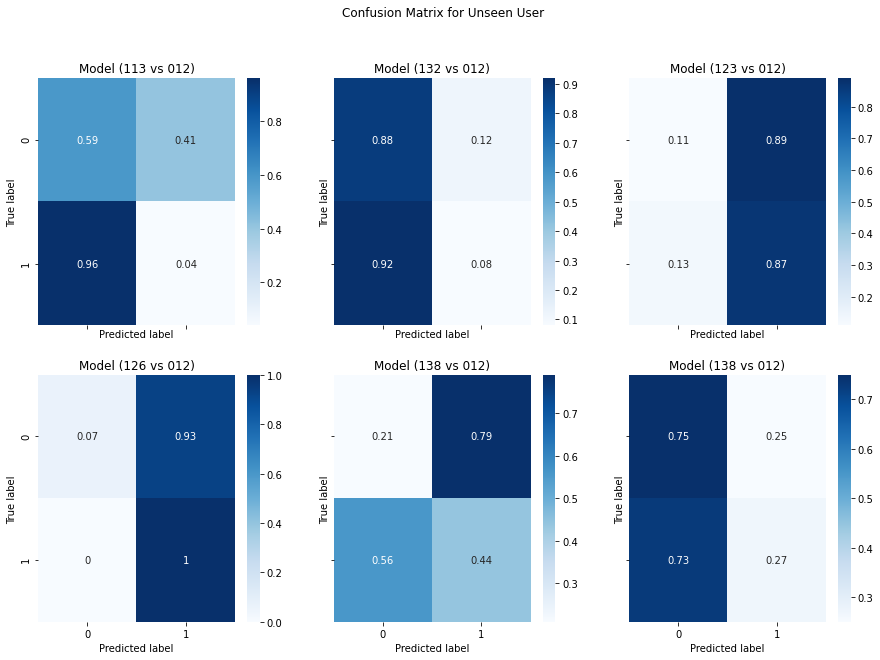

In [58]:
# Plot Confusion Matrix

figure, axis = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True)
figure.suptitle('Confusion Matrix for Unseen User')

def generate_con_mat_df(y_true, y_pred):

  con_mat = confusion_matrix(y_true=y_true,
                             y_pred=y_pred)
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  return pd.DataFrame(con_mat_norm)

axis[0][0].set_title(f"Model ({users_id[0]} vs {impostors_id[1]})")
axis[0][1].set_title(f"Model ({users_id[1]} vs {impostors_id[1]})")
# axis[0][2].set_title(f"Model ({users_id[2]} vs {impostors_id[1]})")
axis[0][2].set_title(f"Model ({users_id[3]} vs {impostors_id[1]})")
axis[1][0].set_title(f"Model ({users_id[4]} vs {impostors_id[1]})")
axis[1][1].set_title(f"Model ({users_id[5]} vs {impostors_id[1]})")
axis[1][2].set_title(f"Model ({users_id[5]} vs {impostors_id[1]})")

sns.heatmap(generate_con_mat_df(y_true_1_unseen, y_pred_1_unseen),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[0][0])
sns.heatmap(generate_con_mat_df(y_true_2_unseen, y_pred_2_unseen),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[0][1])
# sns.heatmap(generate_con_mat_df(y_true_3_unseen, y_pred_3_unseen),
#             annot=True,
#             cmap=plt.cm.Blues, 
#             ax=axis[0][2])
sns.heatmap(generate_con_mat_df(y_true_4_unseen, y_pred_4_unseen),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[0][2])
sns.heatmap(generate_con_mat_df(y_true_5_unseen, y_pred_5_unseen),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[1][0])
sns.heatmap(generate_con_mat_df(y_true_6_unseen, y_pred_6_unseen),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[1][1])
sns.heatmap(generate_con_mat_df(y_true_7_unseen, y_pred_7_unseen),
            annot=True,
            cmap=plt.cm.Blues, 
            ax=axis[1][2])


for ax in axis.flat:
    ax.set(xlabel='Predicted label', ylabel='True label')
#     ax.label_outer()

plt.savefig(f'{saved_files}/Confusion Matrix (Unseen User) {users_id} vs {impostors_id}.png')

In [62]:
!tar -zcvf "/content/saved_files/$(date '+%Y-%m-%d_%H-%M-%S') Kaggle_output.tar.gz" /content/saved_files

tar: Removing leading `/' from member names
/content/saved_files/
/content/saved_files/28-03-2021 00:04:28 123vs050
/content/saved_files/27-03-2021 23:51:25 113vs050
/content/saved_files/ROC Curve (Seen User) ['113', '132', '086', '123', '126', '138', '055']vs['050', '012'].png
/content/saved_files/ROC Curve (Unseen User) ['113', '132', '086', '123', '126', '138', '055']vs['050', '012'].png
/content/saved_files/28-03-2021 00:22:39 055vs050
/content/saved_files/28-03-2021 00:09:51 126vs050
/content/saved_files/27-03-2021 23:57:58 132vs050
/content/saved_files/28-03-2021 00:16:18 138vs050
/content/saved_files/2021-03-28_00-24-40 Kaggle_output.tar.gz
/content/saved_files/Confusion Matrix (Unseen User) ['113', '132', '086', '123', '126', '138', '055'] vs ['050', '012'].png
/content/saved_files/27-03-2021 23:34:13 113vs050
/content/saved_files/Accuracy vs Loss ['113', '132', '086', '123', '126', '138', '055'] vs ['050', '012'].png
/content/saved_files/2021-03-28_00-25-11 Kaggle_output.tar.g

Pairwise User Coupling
===

In [60]:
class TestMethods(unittest.TestCase):

    def test_get_all_user_file_paths(self):
        self.assertEqual(get_all_user_file_paths("001"),
                         ['/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s0/baseline/001001.txt',
                          '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s0/baseline/001000.txt',
                          '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s1/baseline/001100.txt',
                          '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s1/baseline/001101.txt',
                          '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s2/baseline/001201.txt',
                          '/content/drive/MyDrive/Colab_Datasets/UB_keystroke_dataset/s2/baseline/001200.txt'])
        self.assertEqual(get_all_user_file_paths("000"),
                         [])

    def test_split_user_filename(self):
        self.assertEqual(split_user_filename('001001'), ('001', '0', '0', '1'))
        self.assertEqual(split_user_filename('111111'), ('111', '1', '1', '1'))
        self.assertEqual(split_user_filename('1234567'), ('123', '4', '5', '6'))
        with self.assertRaises(IndexError):
            split_user_filename('')

    def test_read_buffalo_user_data(self):
        self.assertTrue(np.array_equal(read_buffalo_user_data('001', '0', '0', '1')[:10],
                                       np.array([('LMenu', 'KeyDown', 63578430829099),
                                                 ('Tab', 'KeyDown', 63578430829224),
                                                 ('Tab', 'KeyUp', 63578430829411),
                                                 ('LMenu', 'KeyUp', 63578430829411),
                                                 ('LMenu', 'KeyDown', 63578430830191),
                                                 ('Tab', 'KeyDown', 63578430830285),
                                                 ('LMenu', 'KeyUp', 63578430830363),
                                                 ('Tab', 'KeyUp', 63578430830409),
                                                 ('LMenu', 'KeyDown', 63578430830565),
                                                 ('Tab', 'KeyDown', 63578430830706)],
                                                 dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')])))
        self.assertTrue(np.array_equal(read_buffalo_user_data('002', '2', '0', '0')[:10],
                                       np.array([('F2', 'KeyDown', 63583872835967), ('F2', 'KeyUp', 63583872836123),
                                                 ('NumPad0', 'KeyDown', 63583872837418),
                                                 ('NumPad0', 'KeyUp', 63583872837480),
                                                 ('NumPad0', 'KeyDown', 63583872837589),
                                                 ('NumPad0', 'KeyUp', 63583872837667),
                                                 ('NumPad0', 'KeyDown', 63583872837745),
                                                 ('NumPad0', 'KeyUp', 63583872837823),
                                                 ('NumPad6', 'KeyDown', 63583872838042),
                                                 ('NumPad6', 'KeyUp', 63583872838135)],
                                                 dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')])))
        with self.assertRaises(OSError):
            read_buffalo_user_data('000', '0', '0', '1')
        
    # def test_read_buffalo_user_data_from_path(self):
    #   self.assertTrue(read_buffalo_user_data_from_path)

    def test_split_down_up(self):
      a, b = split_down_up(np.array([('F2', 'KeyDown', 63583872835967),
                                     ('F2', 'KeyUp', 63583872836123),
                                     ('NumPad0', 'KeyDown', 63583872837418),
                                     ('NumPad0', 'KeyUp', 63583872837480),
                                     ('NumPad0', 'KeyDown', 63583872837589),
                                     ('NumPad0', 'KeyUp', 63583872837667),
                                     ('NumPad0', 'KeyDown', 63583872837745),
                                     ('NumPad0', 'KeyUp', 63583872837823),
                                     ('NumPad6', 'KeyDown', 63583872838042),
                                     ('NumPad6', 'KeyUp', 63583872838135)],
                                     dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]))
      self.assertTrue(np.array_equal(a, np.array([('F2', 'KeyUp', 63583872836123),
                                                  ('NumPad0', 'KeyUp', 63583872837480),
                                                  ('NumPad0', 'KeyUp', 63583872837667),
                                                  ('NumPad0', 'KeyUp', 63583872837823),
                                                  ('NumPad6', 'KeyUp', 63583872838135)],
                                                  dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')])) and
                      np.array_equal(b, np.array([('F2', 'KeyDown', 63583872835967),
                                                  ('NumPad0', 'KeyDown', 63583872837418),
                                                  ('NumPad0', 'KeyDown', 63583872837589),
                                                  ('NumPad0', 'KeyDown', 63583872837745),
                                                  ('NumPad6', 'KeyDown', 63583872838042)],
                                                  dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')])))
      c, d = split_down_up(np.array([('F2', 'ERROR_ACTION', 63583872835967),('F2', 'KeyUp', 63583872836123),
                        ('NumPad0', 'KeyDown', 63583872837418),
                        ('NumPad0', 'ERROR_ACTION', 63583872837480),
                        ('NumPad0', 'KeyDown', 63583872837589),
                        ('NumPad0', 'KeyUp', 63583872837667),
                        ('NumPad0', 'KeyDown', 63583872837745),
                        ('NumPad0', 'KeyUp', 63583872837823),
                        ('NumPad6', 'KeyDown', 63583872838042),
                        ('NumPad6', 'ERROR_ACTION', 63583872838135)],
                        dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]))
      self.assertTrue(np.array_equal(c, np.array([('F2', 'KeyUp', 63583872836123),
                                                  ('NumPad0', 'KeyUp', 63583872837667),
                                                  ('NumPad0', 'KeyUp', 63583872837823)],
                                                  dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')])) and
                      np.array_equal(d, np.array([('NumPad0', 'KeyDown', 63583872837418),
                                                  ('NumPad0', 'KeyDown', 63583872837589),
                                                  ('NumPad0', 'KeyDown', 63583872837745),
                                                  ('NumPad6', 'KeyDown', 63583872838042)],
                                                  dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')])))
      e, f = split_down_up(np.array([],
                                    dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]))
      self.assertTrue(np.array_equal(e, (np.array([],
                                                  dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]))) and
                      np.array_equal(f, np.array([],
                                                 dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')])))
 
                                     
    def test_match_press_release(self):
      self.assertTrue(np.array_equal(match_press_release((np.array([('F2', 'KeyUp', 63583872836123),
                                                                    ('NumPad0', 'KeyUp', 63583872837480),
                                                                    ('NumPad0', 'KeyUp', 63583872837667),
                                                                    ('NumPad0', 'KeyUp', 63583872837823),
                                                                    ('NumPad6', 'KeyUp', 63583872838135)],
                                                                    dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]),
                                                          np.array([('F2', 'KeyDown', 63583872835967),
                                                                    ('NumPad0', 'KeyDown', 63583872837418),
                                                                    ('NumPad0', 'KeyDown', 63583872837589),
                                                                    ('NumPad0', 'KeyDown', 63583872837745),
                                                                    ('NumPad6', 'KeyDown', 63583872838042)],
                                                                    dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]))),
                                      np.array([('F2', 63583872835967, 63583872836123),
                                                ('NumPad0', 63583872837418, 63583872837480),
                                                ('NumPad0', 63583872837589, 63583872837667),
                                                ('NumPad0', 63583872837745, 63583872837823),
                                                ('NumPad6', 63583872838042, 63583872838135)],
                                                dtype=[('Key', '<U16'), ('Press', '<i8'), ('Release', '<i8')])))
      self.assertTrue(np.array_equal(match_press_release((np.array([('F2', 'KeyUp', 63583872836123),
                                                                    ('NumPad0', 'KeyUp', 63583872837667),
                                                                    ('NumPad0', 'KeyUp', 63583872837823)],
                                                                    dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]),
                                                          np.array([('NumPad0', 'KeyDown', 63583872837418),
                                                                    ('NumPad0', 'KeyDown', 63583872837589),
                                                                    ('NumPad0', 'KeyDown', 63583872837745),
                                                                    ('NumPad6', 'KeyDown', 63583872838042)],
                                                                    dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]))),
                                     np.array([('NumPad0', 63583872837589, 63583872837667),
                                               ('NumPad0', 63583872837745, 63583872837823)],
                                               dtype=[('Key', '<U16'), ('Press', '<i8'), ('Release', '<i8')])))
      self.assertTrue(np.array_equal(match_press_release((np.array([], dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]),
                                                          np.array([], dtype=[('Key', '<U16'), ('Action', '<U16'), ('Timestamp', '<i8')]))),
                                     np.empty((0,3), dtype=[('Key', '<U16'), ('Press', '<i8'), ('Release', '<i8')])))


      def test_to_timing_vector(self):
        pass
        

    #   normalise

    #   reshape_to_3d

    #   vec_to_window

    #   auroc
      
    #   create_CNNLSTM

    #   read_and_process_data

    #   save_model
      
    #   perform_training

    #   perform_testing

    #   get_random_users

    #   run

    #   change_hyperparameters

    #   load_model
 	
unittest.main(argv=[''], verbosity=3, exit=False)

test_get_all_user_file_paths (__main__.TestMethods) ... ok
test_match_press_release (__main__.TestMethods) ... ok
test_read_buffalo_user_data (__main__.TestMethods) ... 

FOUND BETWEEN - DROPPING 0 ('NumPad0', 'KeyDown', 63583872837418)
NOT FOUND, IGNORING ('NumPad6', 'KeyDown', 63583872838042)


ok
test_split_down_up (__main__.TestMethods) ... ok
test_split_user_filename (__main__.TestMethods) ... ok

----------------------------------------------------------------------
Ran 5 tests in 1.059s

OK
